In [1]:
!pip install Pillow --quiet
!pip install webdataset==0.1.62
!pip install pytorch-model-summary

  Attempting uninstall: webdataset
    Found existing installation: webdataset 0.1.103
    Uninstalling webdataset-0.1.103:
      Successfully uninstalled webdataset-0.1.103


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.models as models
import torchvision.transforms as T
import numpy as np
import h5py
import os
import sys
import datetime
import csv

import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import logging
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset

# For visualize input
from torch.utils.tensorboard import SummaryWriter
import io
import torchvision
from torchvision import transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from PIL import Image

In [2]:
import webdataset as wds
from itertools import islice
import struct, ast
from importlib_metadata import version

In [3]:
def plot_raw_EEG(data, n_sample):
    numChan = 24
    if len(data[0]) == 2: # torch batch
        x_data = data[:][0]
    else:
        x_data = data
    row = col = int(np.sqrt(n_sample))
    fig = plt.figure(figsize=(row*10, col*10))
    outer = gridspec.GridSpec(row, col)
    print(n_sample)
    for i in range(n_sample):
        inner = gridspec.GridSpecFromSubplotSpec(numChan, 1,
                        subplot_spec=outer[i])
#             npimg = img[i,:,:,:].numpy()
        npimg = x_data[i,:,:,:]
        npimg = np.reshape(npimg,(numChan,256))
        yax = None
        for j in range(numChan):
            ax = plt.Subplot(fig, inner[j])
            ax.plot(range(256),npimg[j,:],'k')
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)

    return fig

In [4]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [12]:
def load_data(path, role, winLength, numChan, srate, feature, one_channel=False, version=""):
    """
    Load dataset
    :param  
        path: Filepath to the dataset
        role: Role of the dataset. Can be "train", "val", or "test"
        winLength: Length of time window. Can be 2 or 15
        numChan: Number of channels. Can be 24 or 128
        srate: Sampling rate. Supporting 126Hz
        feature: Input feature. Can be "raw", "spectral", or "topo"
        one_channel: Where input has 1 or 3 channel in depth dimension. Matters when load topo data as number of input channels 
                are different from original's
        version: Any additional information of the datafile. Will be appended to the file name at the end
    """
    transform = T.Compose([
        T.ToTensor()
    ])
    if version:
        f = h5py.File(path + f"child_mind_x_{role}_{winLength}s_{numChan}chan_{feature}_{version}.mat", 'r')
    else:
        f = h5py.File(path + f"child_mind_x_{role}_{winLength}s_{numChan}chan_{feature}.mat", 'r')
    x = f[f'X_{role}']
    if feature == 'raw':
        x = np.transpose(x,(0,2,1))
        x = np.reshape(x,(-1,1,numChan,winLength*srate))
#         clean_x_idx = []
#         for i in range(x.shape[0]):
#             sample = x[i,:,:,:]
#             if np.max(sample) < 5000 and np.min(sample) > -5000:
#                 clean_x_idx.append(i)
#         print("clean sample amplitude threshold:",len(clean_x_idx))
        
#         clean_subj_idx = []
#         for i in range(0,x.shape[0],81):
# #             print("i:",i)
#             subj_data = x[i:i+80,:,:,:]
            
#             mean_mat = np.mean(subj_data)
#             var_mat = np.var(subj_data)
            
#             subj_data = (subj_data - mean_mat)/var_mat
# #             print(f"sanity check - mean before {mean_mat}, after {np.mean(subj_data)}")
# #             print(f"sanity check - var before {var_mat}, after {np.var(subj_data)}")
            
#             x[i:i+80,:,:,:] = subj_data
            
#             subj_std = np.std(subj_data)
# #             print("subject max:", np.max(subj_data.flatten()))
# #             print("subject std:",subj_std)
#             if subj_std < 5:
#                 clean_subj_idx.extend(list(range(i,i+80)))
#         print("clean sample std<5:",len(clean_subj_idx))
        
#         clean_transient = []
#         for i in range(x.shape[0]):
#             sample = x[i,:,:,:]
#             transient = np.diff(sample, axis=2)
#             assert(transient.shape == (1,24,255))
#             transient_std = np.std(transient)
#             if transient_std < 3:
#                 clean_transient.append(i)
#         print("clean transient std<3:",len(clean_transient))
        
#         clean_idx = intersection(clean_x_idx, clean_subj_idx)
#         clean_idx = intersection(clean_idx, clean_transient)
#         print("num of clean trials:", len(clean_idx))
        
#         x = x[clean_idx,:,:,:]
#         x[x > 200] = 0
#         x[x < -200] = 0
#         min_mat = np.expand_dims(np.min(x,axis=3),3)
#         print(min_mat.shape)
#         assert(min_mat[0,0,0] == np.min(x[0,:,0,:]))
#         assert(min_mat[0,0,1] == np.min(x[0,:,1,:]))
#         range_mat = np.expand_dims(np.ptp(x,axis=3),axis=3)
#         print(range_mat.shape)
#         assert(range_mat[0,0,0] == np.max(x[0,:,0,:])-np.min(x[0,:,0,:]))
#         assert(range_mat[0,0,1] == np.max(x[0,:,1,:])-np.min(x[0,:,1,:]))
#         x = (x - min_mat)/range_mat
#         mean_mat = np.mean(x,axis=(3,0))
#         mean_mat = np.reshape(mean_mat,(1,1,24,1))
#         print(mean_mat.shape)
#         print(np.mean(x,axis=3)[0,0,2])
#         print(np.mean(x[0,0,2,:]))
#         assert(mean_mat[0,0,0][0] == np.mean(x[0,:,0,:]))
#         assert(mean_mat[0,0,1][0] == np.mean(x[0,:,1,:]))
#         var_mat = np.var(x,axis=(3,0))
#         var_mat = np.reshape(var_mat,(1,1,24,1))
#         print(var_mat.shape)
#         assert(range_mat[0,0,0][0] == np.std(x[0,:,0,:]))
#         assert(range_mat[0,0,1][0] == np.std(x[0,:,1,:]))
#         x = (x - mean_mat)/var_mat
#         x = np.nan_to_num(x)
    elif feature == 'topo':
        if one_channel:
            samples = []
            for i in range(x.shape[0]):
                image = x[i]
                b, g, r = image[0,:, :], image[1,:, :], image[2,:, :]
                concat = np.concatenate((b,g,r), axis=1)
                samples.append(concat)
            x = np.stack(samples)
            x = np.reshape(x,(-1,1,x.shape[1],x.shape[2]))
    
    if version:
        f = h5py.File(path + f"child_mind_y_{role}_{winLength}s_{numChan}chan_{feature}_{version}.mat", 'r')
    else:
        f = h5py.File(path + f"child_mind_y_{role}_{winLength}s_{numChan}chan_{feature}.mat", 'r')
    y = f[f'Y_{role}']
#     y = y[clean_idx]
    return EEGDataset(x, y, role=='train', role=='val'), x, y

class EEGDataset(Dataset):
    def __init__(self, x, y, train, val):
        super(EEGDataset).__init__()
#         assert x.shape[0] == y.size
        self.x = x
        self.y = [y[i][0] for i in range(y.size)]
        self.train = train
        self.val = val

    def __getitem__(self,key):
        return (self.x[key], self.y[key])

    def __len__(self):
        return len(self.y)

In [13]:
path = './data/'
winLength = 2
numChan = 24
srate = 128
feature = 'raw'
one_channel = False

role = 'train'
train_data, X, Y = load_data(path, role, winLength, numChan, srate, feature, one_channel)
print(f'X_train shape: {len(train_data)}, {train_data[0][0].shape}')
print(f'Y_train shape: {len(train_data)}, {train_data[0][1].shape}')

X_train shape: 71381, (1, 24, 256)
Y_train shape: 71381, ()


4


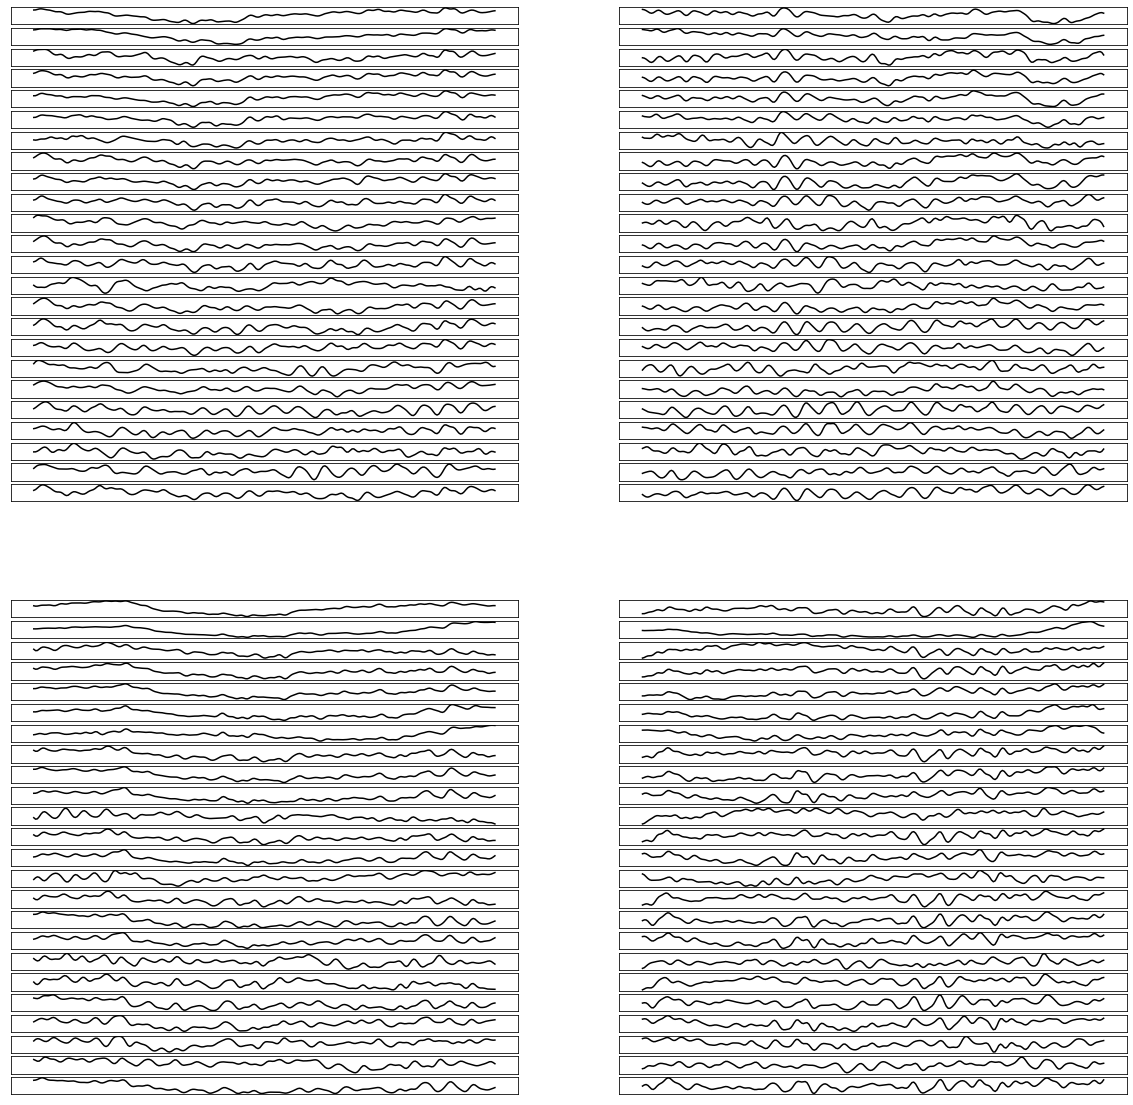

In [27]:
fig = plot_raw_EEG(train_data, 4)

In [28]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

isDebug = False

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

latent_dim = 20
print('latent dimension:', str(latent_dim))
def add_chan_dim(x):
    x = torch.tensor(x)
#     x = torch.transpose(x, 0, 1)
    return torch.unsqueeze(x,0)


def selectLabel(x,lbl):
    # # function to select desired label
    lbl_idx = ["id","sex","age","handedness","index"].index(lbl.lower())
    x = x.decode("utf-8").split(",")
    # return x if lbl_idx == 0 else float(x)
    return 1
    
# s3_url = 'https://childmind.s3.us-west-1.amazonaws.com/python/childmind_train.tar' # replace 'train' with 'val' and 'test' accordingly
# train_data = wds.WebDataset(s3_url).decode().map_dict(npy=add_chan_dim, cls=lambda x: selectLabel(x,'sex')).to_tuple("npy","cls")

# s3_url = 'https://childmind.s3.us-west-1.amazonaws.com/python/childmind_val.tar' # replace 'train' with 'val' and 'test' accordingly
# val_data = wds.WebDataset(s3_url).decode().map_dict(npy=add_chan_dim, cls=lambda x: selectLabel(x,'sex')).to_tuple("npy","cls")

using device: cuda
latent dimension: 20


# Channel distribution

(array([[3.0691e+04, 2.3200e+03, 6.4300e+02, ..., 2.7000e+01, 2.6000e+01,
         8.0000e+00],
        [3.0652e+04, 2.2970e+03, 6.4000e+02, ..., 2.1000e+01, 2.5000e+01,
         1.9000e+01],
        [3.0613e+04, 2.3260e+03, 6.2400e+02, ..., 3.6000e+01, 1.6000e+01,
         1.8000e+01],
        ...,
        [3.0277e+04, 2.1680e+03, 5.8500e+02, ..., 2.4000e+01, 2.2000e+01,
         2.0000e+01],
        [3.0260e+04, 2.2130e+03, 5.6900e+02, ..., 2.0000e+01, 1.2000e+01,
         2.4000e+01],
        [3.0244e+04, 2.1730e+03, 5.8700e+02, ..., 2.4000e+01, 3.0000e+01,
         2.0000e+01]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 256 BarContainer objects>)

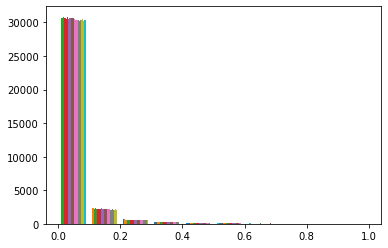

In [9]:
plt.hist(X[:,0,0,:], range=[0,1])

In [ ]:
n,bins,patches = plt.hist(X[:,0,0,:], range=(-150,150)) # first channel as above, data ranges from -200 to 200
print(bins)

[-150. -120.  -90.  -60.  -30.    0.   30.   60.   90.  120.  150.]


In [10]:
test = np.random.rand(1,1,24,256)

In [12]:
arr = np.diff(test,axis=3)

In [13]:
arr.shape

(1, 1, 24, 255)

In [16]:
help(np.intersect)

AttributeError: module 'numpy' has no attribute 'intersect'

In [ ]:
0.5/100